In [21]:
import pandas as pd
import os

citta = 'napoli'
dataset = pd.read_csv('output_'+ citta + '.csv')
dataset.replace('5+', 6, inplace = True)
dataset.replace('3+', 4, inplace = True)
dataset.drop(columns='Unnamed: 0', inplace=True)
dataset = dataset.join(pd.get_dummies(dataset['Zona']))
dataset = dataset.join(pd.get_dummies(dataset['Floor']))
dataset.drop(columns='Zona', inplace=True)
dataset.drop(columns='Floor', inplace=True)
dataset['Price'] = dataset['Price'].str.extract('(\d+)', expand=False)
dataset.fillna(0, inplace=True)
dataset['Price'] = dataset['Price'].astype(int)
dataset['Rooms'] = dataset['Rooms'].astype(int)
dataset['Bathrooms'] = dataset['Bathrooms'].astype(int)
dataset = dataset[(dataset['Price']<= 1100) & (dataset['Price'] > 0)]
obbiettivo = dataset['Price']
dati = dataset.drop(columns= 'Price')
dataset.to_csv('dataset_'+ citta + '.csv')

ValueError: cannot convert float NaN to integer

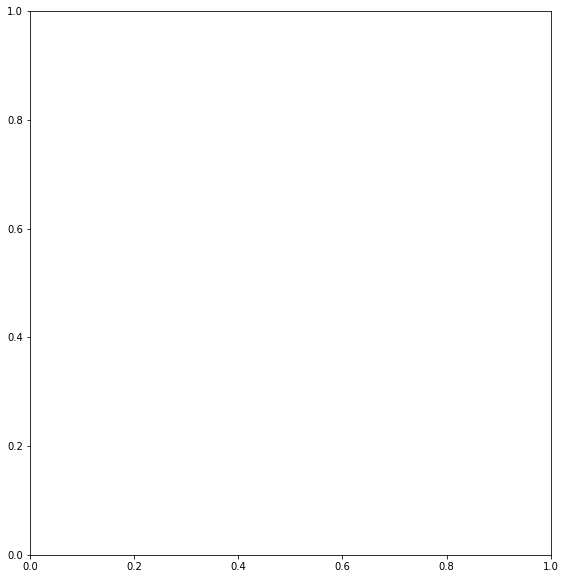

In [22]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )
    
plt.figure(figsize=(10, 10))
corrplot(dataset.corr())

## Allenamento con TPOT

In [ ]:
from tpot import TPOTRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dati.values, obbiettivo.values,
                                                    train_size=0.75, test_size=0.25)

tpot = TPOTRegressor(generations=50, population_size=20, verbosity=2, max_eval_time_mins=2, n_jobs=2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_' + citta + '_pipeline.py')

## Backup TPOT Model

In [ ]:
import pickle

with open('tpot_.pickle','wb') as xx:
    pickle.dump(tpot.fitted_pipeline_,xx)

In [ ]:
with open('tpot_.pickle', 'rb') as xx:
    model = pickle.load(xx)

## Test con TPOT Model

In [ ]:
from scipy.stats.stats import pearsonr
pearsonr(confronto['test'].values, confronto['predictions'].values)

In [ ]:
casa = [[2,24,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]]

In [ ]:
tpot.predict(casa)

## PLOT results

In [ ]:
import matplotlib.pyplot as plot

predictions = []
for item in X_test:
    prediction = tpot.predict([item])
    predictions.append(prediction)

flat_list = []
for sublist in predictions:
    for item in sublist:
        flat_list.append(item)
    
ground_trought = y_test

In [ ]:
confronto = pd.DataFrame()
confronto['test'] = ground_trought
confronto['predictions'] = flat_list

In [ ]:
plt = confronto.plot(figsize=(25,10))
fig = plt.get_figure()
fig.savefig('risultato_tpot' + citta + '.png')
fig.savefig('risultato_tpot' + citta + '.svg')

In [ ]:
diff = confronto['test']-confronto['predictions']
diff.plot()

## Valutazioni Quantitative

In [ ]:
my_dict = list(tpot.evaluated_individuals_.items())

model_scores = pd.DataFrame()
for model in my_dict:
    model_name = model[0]
    model_info = model[1]
    cv_score = model[1].get('internal_cv_score')  # Pull out cv_score as a column (i.e., sortable)
    model_scores = model_scores.append({'model': model_name,
                                        'cv_score': cv_score,
                                        'model_info': model_info,},
                                       ignore_index=True)

model_scores = model_scores.sort_values('cv_score', ascending=False)

In [ ]:
model_scores

In [ ]:
exctracted_best_model = tpot.fitted_pipeline_.steps[-1][1]
exctracted_best_model.feature_importances_
positions= range(exctracted_best_model.feature_importances_.shape[0])
plot.bar(positions, exctracted_best_model.feature_importances_, figsize=(25,10))
plot.show()

## ------------------------------------------------------------

## Allenamento con AUTOML - no Deep

In [23]:
from auto_ml import Predictor
from auto_ml.utils_models import load_ml_model
from sklearn.model_selection import train_test_split

models = ['ARDRegression', 'AdaBoostRegressor', 'BayesianRidge', 'ElasticNet', 'ExtraTreesRegressor', 'GradientBoostingRegressor', 'LassoLars', 'LinearRegression', 'LogisticRegression', 'MiniBatchKMeans', 'OrthogonalMatchingPursuit', 'PassiveAggressiveRegressor', 'Perceptron', 'RANSACRegressor', 'RandomForestRegressor', 'Ridge', 'SGDRegressor']

column_descriptions = {
  'Price': 'output'
}

df_train, df_test = train_test_split(dataset, train_size=0.75, test_size=0.25)

ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions=column_descriptions)
ml_predictor.train(df_train, ml_for_analytics=True, optimize_final_model=False, model_names=models)

# Score the model on test data
test_score = ml_predictor.score(df_test, df_test.Price)

C:\Users\Francesco Manghi\Anaconda3\envs\py37\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.9
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}
Running basic data cleaning
Performing feature scaling
Fitting DataFrameVectorizer
Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{}


********************************************************************************************
About to run GridSearchCV on the pipeline for several models to predict Price
Fitting 2 folds for each of 17 candidates, totalling 34 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  30 out of  34 | elapsed:    4.1s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:    6.2s finished


The best CV score from our hyperparameter search (by default averaging across k-fold CV) for Price is:
-142.56794209326748
The best params were
{'model': 'BayesianRidge'}
Here are all the hyperparameters that were tried:
Score in the following columns always refers to cross-validation score
+--------------+
|   mean_score |
|--------------|
|    -746.7448 |
|    -227.2245 |
|    -208.3755 |
|    -184.4416 |
|    -174.4150 |
|    -169.4876 |
|    -166.5629 |
|    -160.3125 |
|    -157.6084 |
|    -155.8530 |
|    -151.7920 |
|    -150.3654 |
|    -149.0481 |
|    -147.3798 |
|    -144.0265 |
|    -143.5513 |
|    -142.5679 |
+--------------+
Calculating feature responses, for advanced analytics.
Here are our feature responses for the trained model
+----+-------------------------+---------+-------------------+-------------------+-----------+-----------+
|    | Feature Name            |   Delta |   FR_Decrementing |   FR_Incrementing |   FRD_MAD |   FRI_MAD |
|----+-----------------------

## Backup AUTOML

In [27]:
file_name = ml_predictor.save('no_deep_'+citta)
trained_model = load_ml_model(file_name)



We have saved the trained pipeline to a filed called "no_deep_napoli"
It is saved in the directory: 
C:\Users\Francesco Manghi\Documents\GITHUB\house_scraping_and_regression
To use it to get predictions, please follow the following flow (adjusting for your own uses as necessary:


`from auto_ml.utils_models import load_ml_model
`trained_ml_pipeline = load_ml_model("no_deep_napoli")
`trained_ml_pipeline.predict(data)`


Note that this pickle/dill file can only be loaded in an environment with the same modules installed, and running the same Python version.
This version of Python is:
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)


When passing in new data to get predictions on, columns that were not present (or were not found to be useful) in the training data will be silently ignored.
It is worthwhile to make sure that you feed in all the most useful data points though, to make sure you can get the highest quality predictions.


## Test con AUTOML

In [28]:
valutazione = pd.DataFrame()
valutazione['ground_truth'] = df_test['Price'].values
valutazione['predictions'] = trained_model.predict(df_test)


from scipy.stats.stats import pearsonr
pearsonr(valutazione['predictions'].values, valutazione['ground_truth'].values)

(0.6888424917650564, 7.179939163045511e-32)

In [66]:
casa= [[2,24,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]]

In [67]:
trained_model.predict(casa)

340.50258738308685

## PLOT AUTOML

In [29]:
import matplotlib.pyplot as plot

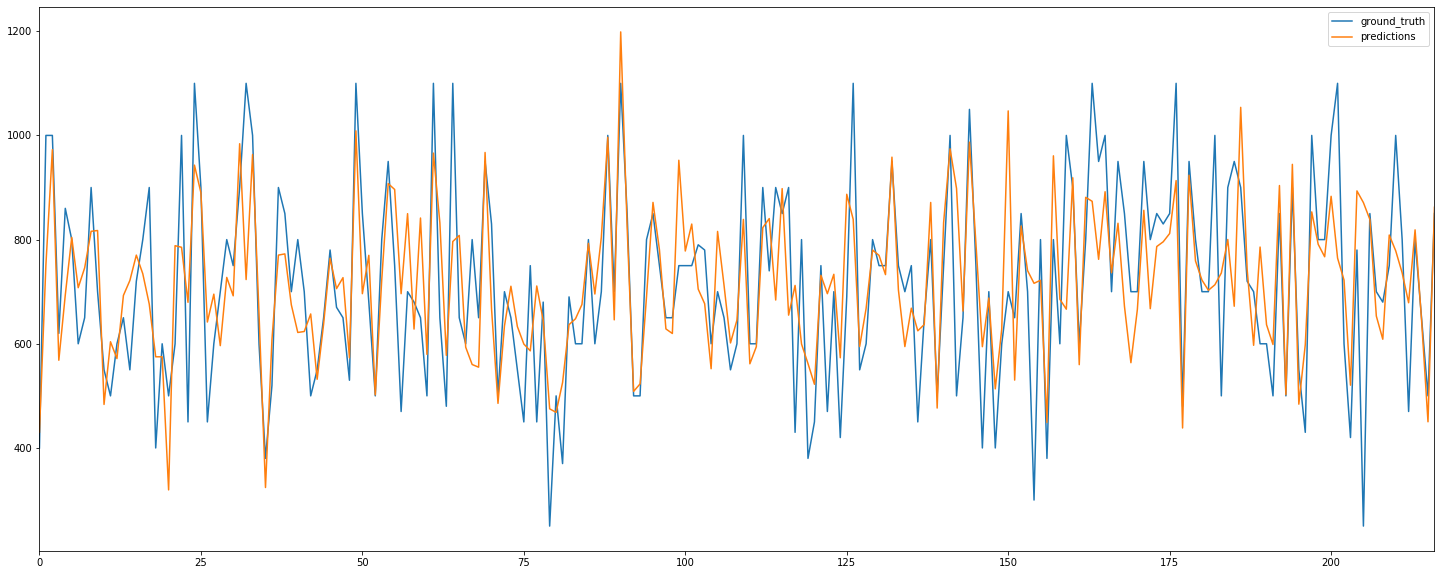

In [30]:
plt = valutazione.plot(figsize=(25,10))
fig = plt.get_figure()
fig.savefig('risultato_automl_' + citta + '.png')
fig.savefig('risultato_automl_' + citta + '.svg')

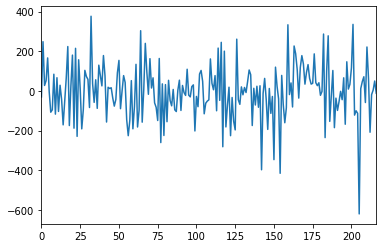

In [31]:
diff = valutazione['ground_truth'] - valutazione['predictions']
diff.plot()

## Allenamento con AUTOML - Deep

In [32]:
from auto_ml import Predictor
from auto_ml.utils_models import load_ml_model
from sklearn.model_selection import train_test_split


column_descriptions = {
  'Price': 'output'
}

df_train, df_test = train_test_split(dataset, train_size=0.75, test_size=0.25)

ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions=column_descriptions)
ml_predictor.train(df_train, feature_learning = True, fl_data = df_test)

# Score the model on test data
test_score = ml_predictor.score(df_test, df_test.Price)

Welcome to auto_ml! We're about to go through and make sense of your data using machine learning, and give you a production-ready pipeline to get predictions with.

If you have any issues, or new feature ideas, let us know at http://auto.ml
You are running on version 2.9.9


Using TensorFlow backend.


Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{'epochs': 1000, 'batch_size': 50, 'verbose': 2}


Running basic data cleaning
Performing feature scaling
Fitting DataFrameVectorizer


********************************************************************************************
About to fit the pipeline for the model DeepLearningRegressor to predict Price
Started at:
2019-10-10 23:53:01

We will stop training early if we have not seen an improvement in validation accuracy in 25 epochs
To measure validation accuracy, we will split off a random 10 percent of your training data set

Train on 184 samples, validate on 33 samples
Epoch 1/1000
 - 1s - loss: 587494.0404 - mean_absolute_error: 740.4321 - mean_absolute_percentage_error: 99.9996 - val_loss: 543049.3125 - val_mean_absolute_error: 709.6890 - val_mean_absolute_percentage_error: 99.9988
Epoch 2/1000
 - 0s - l

C:\Users\Francesco Manghi\Anaconda3\envs\py37\lib\site-packages\keras\engine\sequential.py:111: UserWarning: `Sequential.model` is deprecated. `Sequential` is a subclass of `Model`, you can just use your `Sequential` instance directly.
  warnings.warn('`Sequential.model` is deprecated. '


Now using the model training_params that you passed in:
{}
After overwriting our defaults with your values, here are the final params that will be used to initialize the model:
{'presort': False, 'learning_rate': 0.1, 'warm_start': True}


********************************************************************************************
About to fit the pipeline for the model GradientBoostingRegressor to predict Price
Started at:
2019-10-10 23:53:32
[1] random_holdout_set_from_training_data's score is: -203.171
[2] random_holdout_set_from_training_data's score is: -194.598
[3] random_holdout_set_from_training_data's score is: -187.885
[4] random_holdout_set_from_training_data's score is: -182.114
[5] random_holdout_set_from_training_data's score is: -176.529
[6] random_holdout_set_from_training_data's score is: -171.997
[7] random_holdout_set_from_training_data's score is: -168.819
[8] random_holdout_set_from_training_data's score is: -164.988
[9] random_holdout_set_from_training_data's scor

## Backup AUTOML

In [33]:
file_name = ml_predictor.save('deep_'+citta)
trained_model = load_ml_model(file_name)



We have saved the trained pipeline to a filed called "deep_napoli"
It is saved in the directory: 
C:\Users\Francesco Manghi\Documents\GITHUB\house_scraping_and_regression
To use it to get predictions, please follow the following flow (adjusting for your own uses as necessary:


`from auto_ml.utils_models import load_ml_model
`trained_ml_pipeline = load_ml_model("deep_napoli")
`trained_ml_pipeline.predict(data)`


While saving the trained_ml_pipeline, we found a number of deep learning models that we saved separately.
Make sure to transfer these files to whichever environment you plan to load the trained pipeline in
Specifically, we saved 1 deep learning models to separate files
Note that this pickle/dill file can only be loaded in an environment with the same modules installed, and running the same Python version.
This version of Python is:
sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)


When passing in new data to get predictions on, columns that were n

C:\Users\Francesco Manghi\Anaconda3\envs\py37\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Test con AUTOML

In [34]:
valutazione = pd.DataFrame()
valutazione['ground_truth'] = df_test['Price'].values
valutazione['predictions'] = trained_model.predict(df_test)


from scipy.stats.stats import pearsonr
pearsonr(valutazione['predictions'].values, valutazione['ground_truth'].values)

(0.7902742651752057, 1.2666510385115303e-47)

In [74]:
casa= [[2,24,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]]

In [75]:
trained_model.predict(casa)

375.93485164190383

## PLOT AUTOML

In [35]:
import matplotlib.pyplot as plot

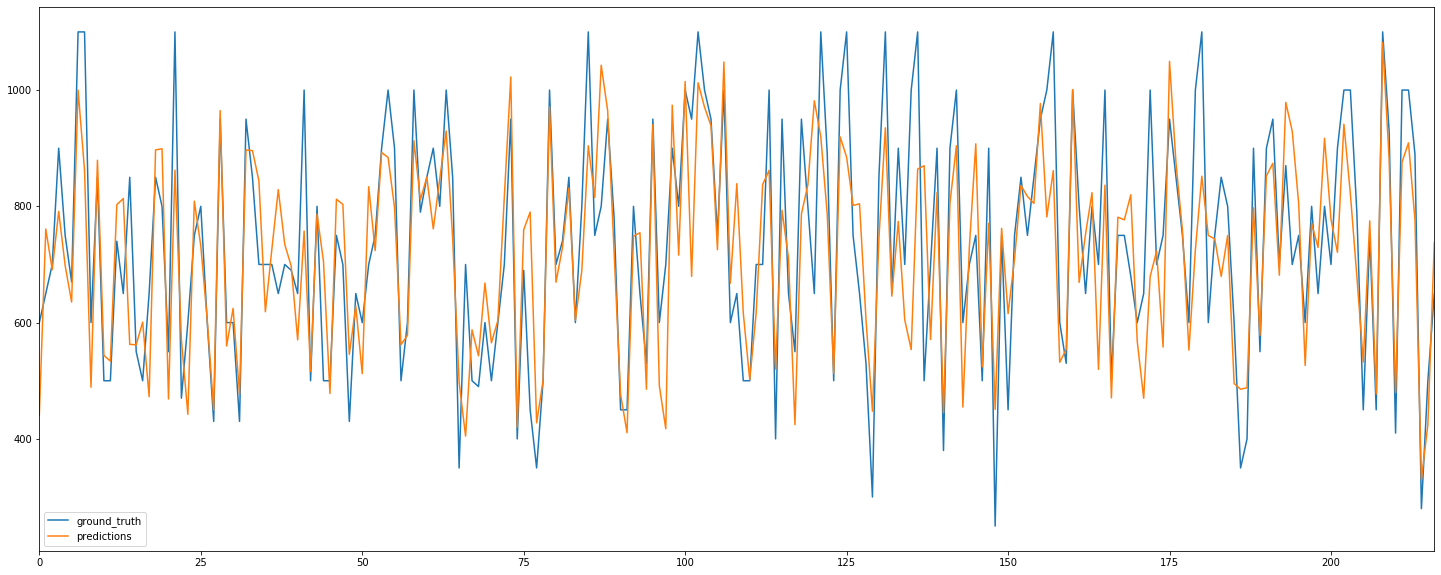

In [37]:
plt = valutazione.plot(figsize=(25,10))
fig = plt.get_figure()
fig.savefig('risultato_automl_deep_' + citta + '.png')
fig.savefig('risultato_automl_deep_' + citta + '.svg')

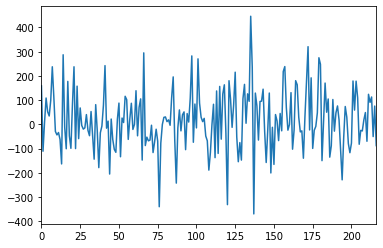

In [38]:
diff = valutazione['ground_truth'] - valutazione['predictions']
diff.plot()